In [ ]:
# TODO
# Make if statement to ensure there CS2 coverage over that lake 
# to plot that part (otherwise recursion error)
# Make plotting and saving time series fig separate functions 
# so that not every polygon removal plot is saved, just the last one
# Fix plot_evolving_outlines_dArea
# Make plot_evolving_outlines_dArea_dHeight_dVol

# Computing environment setup

# Set up computing environment

In [1]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install import cv2

In [3]:
# Code to create fig. X in Sauthoff and others, 2023
#
# Written 2023-09-06 by W. Sauthoff (sauthoff@mines.edu)

# Import packages
# import cv2
import datetime
import math
import matplotlib.cm as cm
import matplotlib.colors as colors  # delete when no longer needed
import matplotlib.dates as mdates
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import openpyxl
from pathlib import Path
from pyproj import CRS, Transformer
import os
import rioxarray
from skimage import measure
import warnings
import xarray as xr

# Suppress all warnings
warnings.filterwarnings("ignore")

# Reset warnings to default (optional)
# warnings.resetwarnings()

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    # DATA_DIR = '/home/jovyan/data_dir'
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Users/Wilson/Documents/data'
    # DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'
    OUTPUT_DIR = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer

# Define utility functions
def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    Inputs
    * lon, lat in decimal degrees (lon: W is negative; lat: S is negative)
    Outputs
    * x, y polar stereographic 71 in m
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

# Change default font to Arial and increase font size
# plt.rcParams["font.family"] = 'Arial'
# plt.rcParams.update({'font.size': 22})
# plt.rcParams["font.family"] = 'sans-serif' # set back to default

In [4]:
"""
io.py
Written by Tyler Sutterley (08/2023)
Utilities for reading gridded ICESat-2 files using rasterio and xarray

PYTHON DEPENDENCIES:
    h5netcdf: Pythonic interface to netCDF4 via h5py
        https://h5netcdf.org/
    numpy: Scientific Computing Tools For Python
        https://numpy.org
        https://numpy.org/doc/stable/user/numpy-for-matlab-users.html
    rasterio: Access to geospatial raster data
        https://github.com/rasterio/rasterio
        https://rasterio.readthedocs.io
    rioxarray: geospatial xarray extension powered by rasterio
        https://github.com/corteva/rioxarray
    xarray: N-D labeled arrays and datasets in Python
        https://docs.xarray.dev/en/stable/

UPDATE HISTORY:
    Updated 08/2023: use xarray h5netcdf to read files streaming from s3
        add open_dataset function for opening multiple granules
        add merging of datasets in preparation for Release-3 data
    Updated 07/2023: use logging instead of warnings for import attempts
    Written 11/2022
"""
from __future__ import annotations
import os
import logging

# attempt imports
try:
    import rioxarray
    import rioxarray.merge
except (AttributeError, ImportError, ModuleNotFoundError) as exc:
    logging.critical("rioxarray not available")
try:
    import xarray as xr
except (AttributeError, ImportError, ModuleNotFoundError) as exc:
    logging.critical("xarray not available")

# set environmental variable for anonymous s3 access
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# default engine for xarray
_default_engine = dict(nc='h5netcdf', zarr='zarr')

def open_dataset(granule,
        group: str | None = None,
        format: str = 'nc',
        **kwargs
    ):
    """
    Reads and optionally merges gridded ICESat-2 files

    Parameters
    ----------
    granule: str or list
        presigned url or path for granule(s) as a s3fs object
    group: str or NoneType, default None
        Data group to read
    format: str, default 'nc'
        Data format to read
    kwargs: dict
        Keyword arguments to pass to ``xarray`` reader

    Returns
    -------
    ds: object
        ``xarray`` dataset
    """
    # check if merging multiple granules
    if isinstance(granule, list):
        # merge multiple granules
        datasets = []
        # read each granule and append to list
        for g in granule:
            datasets.append(from_file(g,
                group=group,
                format=format,
                **kwargs)
            )
        # merge datasets
        ds = rioxarray.merge.merge_datasets(datasets)
    else:
        # read a single granule
        ds = from_file(granule,
            group=group,
            format=format,
            **kwargs
        )
    # return the dataset
    return ds

def from_file(granule,
        group: str | None = None,
        format: str = 'nc',
        **kwargs
    ):
    """
    Reads a gridded ICESat-2 file using ``rioxarray`` or ``xarray``

    Parameters
    ----------
    granule: str
        presigned url or path for granule
    group: str or NoneType, default None
        Data group to read
    format: str, default 'nc'
        Data format to read
    kwargs: dict
        Keyword arguments to pass to ``xarray`` reader

    Returns
    -------
    ds: object
        ``xarray`` dataset
    """
    # set default engine
    kwargs.setdefault('engine', _default_engine[format])
    if isinstance(granule, str) and format in ('nc',):
        ds = from_rasterio(granule,
            group=group,
            **kwargs
        )
    else:
        # read a single granule
        ds = from_xarray(granule,
            group=group,
            **kwargs
        )
    # return the dataset
    return ds

def from_rasterio(granule,
        group: str | None = None,
        **kwargs
    ):
    """
    Reads a gridded ICESat-2 file using ``rioxarray``

    Parameters
    ----------
    granule: str
        presigned url or path for granule
    group: str or NoneType, default None
        Data group to read
    kwargs: dict
        Keyword arguments to pass to ``rioxarray``

    Returns
    -------
    ds: object
        ``xarray`` dataset
    """
    ds = rioxarray.open_rasterio(granule,
        group=group,
        masked=True,
        **kwargs
    )
    return ds


def from_xarray(granule,
        group: str | None = None,
        engine: str = 'h5netcdf',
        **kwargs
    ):
    """
    Reads a gridded ICESat-2 file using ``xarray``

    Parameters
    ----------
    granule: str
        presigned url or path for granule
    group: str or NoneType, default None
        Data group to read
    engine: str, default 'h5netcdf'
        Engine to use when reading files
    kwargs: dict
        Keyword arguments to pass to ``xarray``

    Returns
    -------
    ds: object
        ``xarray`` dataset
    """
    kwargs.setdefault('variable', [])
    variable = kwargs.pop('variable')
    # read xarray dataset
    ds = xr.open_dataset(granule,
        group=group,
        engine=engine,
        chunks='auto',
        decode_cf=True,
        mask_and_scale=True,
        decode_times=False,
        concat_characters=True,
        decode_coords=True,
        overwrite_encoded_chunks=False,
        **kwargs
    )
    # set the coordinate reference system
    ds.rio.write_crs(ds.Polar_Stereographic.attrs['crs_wkt'], inplace=True)
    # reduce xarray dataset to specific variables
    if any(variable):
        ds = ds[variable]
    # flip orientation of y dimension
    ds = ds.isel(y=slice(None, None, -1))
    return ds

# Import datasets

In [5]:
CS2_dh = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2021.5.nc')
CS2_dh

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 45)
Coordinates:
  * y            (y) float64 2.265e+06 2.264e+06 ... -2.184e+06 -2.185e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) float64 2.01e+03 2.011e+03 ... 2.021e+03 2.022e+03
Data variables:
    mask         (y, x) float64 ...
    delta_h      (time, y, x) float64 ...
    count        (time, y, x) float64 ...
    spatial_ref  int64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [ ]:
# Import ICESat-2 ATL15 Gridded Antarctic and Arctic Land Ice Height Change data product 
# https://doi.org/10.5067/ATLAS/ATL15.002
if os.getenv('HOME') == '/home/jovyan':
    # FIXME: temporary workaround  
    # TODO: Grab ATL15 data using earthaccess or icepyx
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
    granules = ['s3://is2view/ATLAS/ATL15/003/2019/ATL15_A1_0318_01km_003_01.nc',
        's3://is2view/ATLAS/ATL15/003/2019/ATL15_A2_0318_01km_003_02.nc',
        's3://is2view/ATLAS/ATL15/003/2019/ATL15_A3_0318_01km_003_01.nc',
        's3://is2view/ATLAS/ATL15/003/2019/ATL15_A4_0318_01km_003_03.nc']
    ATL15_dh = open_dataset(granules, 
        group='delta_h', engine='h5netcdf')
    ATL15_dh
    
elif os.getenv('HOME') == '/Users/Wilson': 
# if os.getenv('HOME') == '/Users/Wilson':
    # TODO: Grab ATL15 data using earthaccess or icepyx
    # s3url = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'
    # FIXME: temporary workaround
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
    # granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A1_0318_01km_003_01.nc'
    # group = 'delta_h'
    # ATL15_dh_A1 = rioxarray.open_rasterio(granule, group=group, masked=True)
    # granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A2_0318_01km_003_02.nc'
    # group = 'delta_h'
    # ATL15_dh_A2 = rioxarray.open_rasterio(granule, group=group, masked=True)
    granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A3_0318_01km_003_01.nc'
    group = 'delta_h'
    ATL15_dh_A3 = rioxarray.open_rasterio(granule, group=group, masked=True)
    # granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A4_0318_01km_003_03.nc'
    # group = 'delta_h'
    # ATL15_dh_A4 = rioxarray.open_rasterio(granule, group=group, masked=True)

    # Add a new attribute
    # ATL15_dh.attrs['title'] = 'Gridded Antarctic Land Ice Height Change'

In [ ]:
ATL15_dh

In [ ]:
# Ensure dates acquisition working
dates = []
dataset1 = CS2_dh
dataset2 = ATL15_dh
for idx in range(len(dataset1.delta_h[:-12])):
    dhdt = dataset1.delta_h[idx+1,:,:]-dataset1.delta_h[idx,:,:]
    # calculate mid-cycle dates for plotting
    newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
    newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
for idx in range(len(dataset2.delta_h)-1): 
    dhdt = dataset2.delta_h[idx+1,:,:]-dataset2.delta_h[idx,:,:]
    date_time_str = '18-01-01'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
    newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
dates

In [ ]:
# Import subglacial lake outline inventories
# exec(open(SCRIPT_DIR + '/Smith2009_outlines.py').read())
# exec(open(SCRIPT_DIR + '/SiegfriedFricker2018_outlines.py').read())
# Will earlier two inventories load using the 2023 py script
exec(open(SCRIPT_DIR + '/Sauthoff2023_outlines.py').read())

In [ ]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# https://nsidc.org/data/nsidc-0593/versions/1
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2009/moa_2009_coastline_v02.0.shp' 
# moa_2009_coastline = gpd.read_file(shp)
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2009/moa_2009_groundingline_v02.0.shp' 
# moa_2009_groundingline = gpd.read_file(shp)
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [ ]:
# Clip CS2_dh to grounding line (first set crs)
# CS2_dh.rio.write_crs(3031, inplace=True)
# CS2_dh_clipped = CS2_dh.rio.clip(moa_2014_groundingline.geometry.values, moa_2014_groundingline.crs, drop=False)

In [ ]:
# clip ATL15_dh to grounding line (first set crs)
# ATL15_dh.rio.write_crs(3031, inplace=True)
# ATL15_dh_clipped = ATL15_dh.rio.clip(moa_2014_groundingline.geometry.values, moa_2014_groundingline.crs, drop=False)

# Functions

The following functions enable a workflow to define region of interest, find evolving contours of delta height, plot results, refine those results to manually remove signal that is likely not related to subglacial lake activity, and export the evolving outlines and delta area time series.
* func for finding bbox coords for region of interest
* func to make directories to store output of latter func's
* func for contouring creating plots for each differenced time slice including saving plots and a gdf of the evolving outlines
* func to plot evolving outlines in aggregate
* func to remove non-overlapping outlines
* func to remove most extreme polygon to clean up outlines that are off-lake
* func to take modified gdf and calculated delta area per time slice and export as csv
* func to plot evolving outlines in aggregate and the dVol time series

In [ ]:
def find_bbox_coords(ROI, buffer):
    '''
    Func to find the bounding box coordinates of a region of interest
    
    Inputs
    * ROI: Region of interest in form of a lake name from Sauthoff and others, 2024 inventory (Sauthoff2024_outlines),
    IMBIE basin or refinded basins, or list of x_min, x_max, y_min, y_max bbox coords
    * buffer: horizontal distance in meters that will be added to each edge of the ROI to include in the bbox
    
    Outputs:
    * x_min, x_max, y_min, y_max bbox coords
    * datasets clipped to ROI ????
    '''
    if Sauthoff2023_outlines['name'].str.contains(ROI).any():
        # Isolate individual lake using gpd buffer
        lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == ROI]  
        lake_gpd
        lake_buffer = lake_gpd.buffer(buffer)
        # Define lake bounding box
        x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
        y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
        
        # # Clip dataset to region of interest
        
    elif IMBIE_basins['NAME'].str.contains(ROI).any():
        # Isolate individual basin as geodf
        basin = IMBIE_basins[IMBIE_basins['NAME'] == region_or_lake]

        # Define region bounding box
        x_min = basin.geometry.bounds.minx.values[0]; x_max = basin.geometry.bounds.maxx.values[0]
        y_min = basin.geometry.bounds.miny.values[0]; y_max = basin.geometry.bounds.maxy.values[0]
        
        # # Clip dataset to IMBIE basin of interest
        # ds_clipped = dataset.rio.clip(basin.geometry.values, basin.crs)
        
    elif len(ROI)==2:
        x_min = ROI[0]-buffer; x_max = ROI[0]+buffer
        y_min = ROI[1]-buffer; y_max = ROI[1]+buffer     
    
    elif len(ROI)==4: 
        x_min = ROI[0]; x_max = ROI[1]
        y_min = ROI[2]; y_max = ROI[3]
        
    return x_min, x_max, y_min, y_max

In [ ]:
def make_dirs(func_name):
    '''
    Make appropriate directories if they don't already exist and
    create Path objects for the given file paths
    
    Inputs
    * func name (str) for where you'd like to store output and
    store the Path objects
    
    Outputs
    * tuple: A tuple containing two Path objects representing the file paths.
    '''
    png_path = OUTPUT_DIR + '/figX_subglacial_lake_areas/{}/png'.format(func_name)
    avi_path = OUTPUT_DIR + '/figX_subglacial_lake_areas/{}/avi'.format(func_name)
    paths = [png_path, avi_path]
    for i in paths: 
        if not os.path.exists(i):
            os.makedirs(i)

    return Path(png_path), Path(avi_path)

# Example usage
# (png_path, avi_path) = make_dirs_file_paths('find_evolving_contours')

In [ ]:
def create_dirs(folder_names, base_directory='.'):
    '''
    Make appropriate directories if they don't already exist and
    
    Inputs
    * folder names as list
    * base directory to put new folders
    
    Outputs
    * makes directories if they don't already exist
    '''
    for folder_name in folder_names:
        folder_path = os.path.join(base_directory, folder_name)

        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created at '{folder_path}'")
        except FileExistsError:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'")

# # Example usage:
# folder_list = ['Folder1', 'Folder2', 'Folder3']
# create_folders(folder_list)

In [ ]:
def create_ROI_dirs(base_directory='.'):
    '''
    Make appropriate directories if they don't already exist and
    
    Inputs
    * base directory to put new folders
    
    Outputs
    * makes directories if they don't already exist
    '''
    for i in Sauthoff2023_outlines['name']:
        folder_name = str(i)
        folder_path = base_directory + '/' + folder_name

        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created at '{folder_path}'")
        except FileExistsError:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'")
            
    # IMBIE basins
            
# Example usage
# make_ROI_dirs(base_directory='.')

In [ ]:
def find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs: 
    * x_min, x_max, y_min, y_max: polar stereographic coords
    * threshold: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''

    # Subset CryoSat-2 SARIn data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
    # Subset ATL15 data set to region of interest
    mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)

    # Create lines for legend
    uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            midcycdates += [midcycdate]
    for idx in range(len(dataset2.delta_h)-1): 
        # ICESat-2 ATL15 r003
        if dataset2.identifier_product_DOI == 'NOT_SET':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            cyc_end_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    datetimes = []

    # Calculate cycle-to-cycle dh/dt at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)-1): 
        if idx < 35:
            dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds1_clipped.delta_h[idx,:,:]
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcycdate = midcyc_dates[idx]

        elif idx > 34:
            dhdt = ds2_clipped.delta_h[(idx-40)+1,:,:]-ds2_clipped.delta_h[idx-40,:,:]
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcycdate = midcyc_dates[idx]

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]

        # Create fig, ax
        fig, ax = plt.subplots()

        # Plot figure
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap='coolwarm_r', 
            norm=colors.CenteredNorm())
        
        # Create empty lists to store contours 
        contours_pos = []
        contours_neg = []

        # For loop to create contours of each threshold given 
        contour = measure.find_contours(dhdt.values, threshold)
        if len(contour) > 0: 
            contours_pos += [contour]
        contour = measure.find_contours(dhdt.values, -threshold)
        if len(contour) > 0: 
            contours_neg += [contour]

        # Plot contours and make into polygons
        for i in range(len(contours_pos)): 
            for j in range(len(contours_pos[i])):
                x = x_min+contours_pos[i][j][:,1]*x_conv
                y = y_max-contours_pos[i][j][:,0]*y_conv
                ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)
                
                # Make polygons from variable outlines and store to list
                if len(contours_pos[i][j][:,1]) > 2: 
                    poly = Polygon(list(zip(x, y))) 
                    polys += [poly]
                    
                    # Calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]

        for i in range(len(contours_neg)): 
            for j in range(len(contours_neg[i])):
                x = x_min+contours_neg[i][j][:,1]*x_conv
                y = y_max-contours_neg[i][j][:,0]*y_conv
                ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)
                
                # Make polygons from variable outlines
                if len(contours_neg[i][j][:,1]) > 2: 
                    poly = Polygon(list(zip(x, y)))
                    polys += [poly]
                    
                    # Calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]

        # Overlay published active lake outlines for visual comparison and grounding line
        S09_color = 'cyan'
        SF18_color  = 'darkcyan'
        S23_color = 'deepskyblue'
        Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
        Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
        SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
        SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
        Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
        Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)
        
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  

        # Label axes, set limits, and set title
        ax.set_xlabel('x [m]', size=15)
        ax.set_ylabel('y [m]', size=15) 
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        ax.set_title('dh between {} and {}'.format(cyc_start_date.date(), 
            cyc_end_date.date()), size=15)

        # Plot inset map
        axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        
        # Plot black rectangle to indicate location
        # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        # axIns.add_artist(rect)
        
        # Plot red star to indicate location
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
        axIns.axis('off')

        # Add colorbar 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)
        
        # Add legend
        ax.legend([uplift, subsidence],
            [('+ '+str(threshold)+' m uplift (filling) evolving outline'), 
             ('– '+str(threshold)+' m subsidence (draining) evolving outline')], 
            loc='upper left')
        
        # Save and close fig
        plt.savefig(OUTPUT_DIR + 
            '/figX_subglacial_lake_areas/find_evolving_outlines/png/{}/find_evolving_outlines{}_{}km-buffer_{}m-threshold_{}-{}.png'
            .format(ROI, ROI, buffer/1e3, threshold, cyc_start_date.date(), cyc_end_date.date()), dpi=300, bbox_inches='tight')
        plt.close()
    
    # # Create avi video from figs created of each differenced time slice
    # # Create video name
    # video_name = '/evolving_contours_{}_{}km-buffer_{}m-threshold.avi'.format(ROI, buffer/1e3, threshold)
    # # Store individual frames
    # images = [img for img in os.listdir(png_path) if img.endswith(".png")]
    # # Create frame dimension
    # frame = cv2.imread(os.path.join(png_path, images[0]))
    # height, width, layers = frame.shape
    # # VideoWriter object will create a frame 
    # video = cv2.VideoWriter(avi_path + video_name, 0, 1, (width,height))
    # for image in images:
    #     video.write(cv2.imread(os.path.join(png_path, image)))
    # # Close all the frames
    # cv2.destroyAllWindows()
    # # Release the video write object
    # video.release()

    # Store polygons in geopandas geodataframe for further analysis
    d = {'geometry': polys, 'evolving area (km^2)': areas, 'perim (km)': perims, 'datetime': datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['date'] = pd.to_datetime(gdf['datetime']).apply(lambda x: x.date())

    return gdf

# # Example usage
# gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)

In [ ]:
def plot_evolving_outlines_time_series(gdf):
    '''
    Func to plot evolving outlines in aggregate
    '''
    # Set up dataset
    dataset1 = CS2_dh
    dataset2 = ATL15_dh

    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            midcycdates += [midcycdate]
    for idx in range(len(dataset2.delta_h)-1): 
        # ICESat-2 ATL15 r003
        if dataset2.identifier_product_DOI == 'NOT_SET':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            cyc_end_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]

    # create fig, ax
    fig, ax = plt.subplots(figsize=(15,15))

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(dates)-1)
    norm = plt.Normalize(datetime2fracyear(dates[0]), datetime2fracyear(dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.9)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=25)

    # Add black background to see outlines better
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S23_color = 'deepskyblue'
    Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(dates[0:-1], 0):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime2fracyear(dates[idx]))), linewidth=3)
        lines.append(line)
        if any(gdf[gdf['datetime'] == dt]): 
            gdf[gdf['datetime'] == dt].boundary.plot(ax=ax, 
                color=cmap(norm(datetime2fracyear(dates[idx])))
                )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 10)), linewidth=3)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 5)), linewidth=3)
    
    # Create legend
    ax.legend(handles=[Smith2009, 
        SiegfriedFricker2018, 
        tuple(lines)], 
        labels=['Smith and others, 2009 static outline',
            'Siegfried & Fricker, 2018 outline', 
            'evolving outline ({} m threshold)'.format(threshold)], handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    axIns.add_artist(rect) 
    axIns.axis('off')

    plt.savefig(OUTPUT_DIR + '/figX_subglacial_lake_areas/plot_evolving_outlines_time_series/{}/plot_evolving_outlines_time_series_{}_{}km-buffer_{}m-threshold-{}outlines.png'
        .format(ROI, ROI, buffer/1e3, threshold, len(gdf)),
                dpi=300, bbox_inches='tight')

    # plt.close()

In [ ]:
def find_overlapping_polygons(gdf):
    '''
    Func to separate overlapping and non-overlapping polygons
    stored in one geopandas geodataframe into two geopandas 
    geodataframes
    
    Inputs
    * geopandas geodataframe
    
    Outputs
    * two geopandas geodataframes, one with overlapping polygons,
    one with non-overlapping polygons
    '''
    overlapping = []
    non_overlapping = []
    for n, p in enumerate(list(gdf.geometry), 0):
        if any(p.overlaps(g) for g in list(gdf.geometry)):
            # Store the index from the original dataframe
            overlapping.append(n)
        if not any(p.overlaps(g) for g in list(gdf.geometry)):
            non_overlapping.append(n)

    # Create a new dataframes and reset their indexes
    gdf_overlapping = gdf.iloc[overlapping]  
    gdf_overlapping.reset_index(drop=True, inplace=True)
    gdf_non_overlapping = gdf.iloc[non_overlapping]
    gdf_non_overlapping.reset_index(drop=True, inplace=True)
    
    return gdf_overlapping

In [ ]:
def remove_outlier_polygon(gdf, axis='x', max_or_min='max'):
    '''
    Func to remove outline outliers by removing a polygon
    with the most extreme x or y coordinates
    
    Inputs
    * geopandas geodataframe
    * axis indicates whether the x or y axis will 
    have its extreme polygon removed
    * max_or_min indicates whether the max or min centroid axis
    value will be removed
    
    Ouputs
    * geopandas geodataframe with one outline removed
    '''
    
    # Check if the GeoDataFrame is empty
    if gdf.empty:
        print("GeoDataFrame is empty. Nothing to remove.")
        return gdf
    
    # Choose the axis and max or min for extreme value
    if axis not in ['x', 'y']:
        raise ValueError("Invalid axis. Use 'x' or 'y'.")
    if max_or_min not in ['max', 'min']:
        raise ValueError("Invalid max_or_min. Use 'max' or 'min'.")

    # Calculate the centroid and extreme value
    if axis == 'x':
        if max_or_min == 'max':
            idx_to_remove = gdf.geometry.bounds['maxx'].idxmax()
        else:
            idx_to_remove = gdf.geometry.bounds['minx'].idxmin()
    else:
        if max_or_min == 'max':
            idx_to_remove = gdf.geometry.bounds['maxy'].idxmax()
        else:
            idx_to_remove = gdf.geometry.bounds['miny'].idxmin()

    # Remove the polygon with the specified polygon index to remove
    gdf_filtered = gdf.drop(idx_to_remove)

    print(f"Removed polygon with extreme {max_or_min} {axis}-value at index {idx_to_remove}.")

    return gdf_filtered

# Example usage:
# Assuming 'gdf' is your GeoDataFrame
# new_gdf = remove_extreme_polygon(gdf, axis='x', positive=True)

In [ ]:
def csv_export(ROI, gdf):
    '''
    Func to take modified gdf and calculated delta area per time slice and export as csv
    '''
    if Sauthoff2023_outlines['name'].str.contains(ROI).any():
        # Isolate individual lake using gpd buffer
        lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == ROI]  
        gdf['static area (km^2)'] = np.divide(sum(lake_gpd.area), 1e6)
    gdf.to_csv(OUTPUT_DIR + '/figX_subglacial_lake_areas/csv_export/area_time_series_{}.csv'.format(ROI),
        columns=['date', 'static area (km^2)', 'evolving area (km^2)'])

In [ ]:
def plot_evolving_outlines_dArea(ROI, gdf):
    '''
    Func to plot evolving outlines in aggregate and the dArea time series
    '''
    # lake_S09 = Smith2009_outlines[(Smith2009_outlines['Name'] == 'Whillans_7')]
    # S09_color = 'lightseagreen'

    fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(15,5))

    # Plot 0 - plot evolving outlines
    # Set up dataset
    dataset1 = CS2_dh
    dataset2 = ATL15_dh

    # Find mid-cycle dates of combined CS2 and IS2 data
    dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
    for idx in range(len(dataset2.delta_h)-1): 
        if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(dates)-1)
    norm = plt.Normalize(datetime2fracyear(dates[0]), datetime2fracyear(dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.9)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=25)

    # Add black background to see outlines better
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S23_color = 'deepskyblue'
    Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(dates[0:-1], 0):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime2fracyear(dates[idx]))), linewidth=3)
        lines.append(line)
        gdf[gdf['datetime'] == dt].boundary.plot(ax=ax, 
            color=cmap(norm(datetime2fracyear(dates[idx])))
            )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 10)), linewidth=3)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 5)), linewidth=3)
    
    # Create legend
    ax.legend(handles=[Smith2009, 
        SiegfriedFricker2018, 
        tuple(lines)], 
        labels=['Smith and others, 2009 static outline',
            'Siegfried & Fricker, 2018 outline', 
            'evolving outline ({} m threshold)'.format(threshold)], handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    axIns.add_artist(rect) 
    axIns.axis('off')

    # Plot 1 - plot area change time series
    axs[1].axhline(np.divide(sum(lake_S09.area), 1e6), color=S09_color, linestyle=(0, (1, 4)))
    axs[1].plot(dates_unique, areas_evolving, color='k', linestyle=(0, (1, 1)))
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    axs[1].xaxis.set_major_locator(locator)
    axs[1].xaxis.set_major_formatter(formatter)
    min_area = min(np.divide(sum(lake_S09.area), 1e6), 
                    # np.divide(sum(lake_SF18.area), 1e6), 
                    min(areas_evolving))
    max_area = max(np.divide(sum(lake_S09.area), 1e6), 
                    # np.divide(sum(lake_SF18.area), 1e6), 
                    max(areas_evolving))
    axs[1].set(ylim=((min_area - (max_area - min_area)*0.05), (max_area + (max_area - min_area)*0.05)),
        xlim=(dates[0], dates[-1]))
    axs[1].set_ylabel('lake area [km$^2$]', size=17.5, labelpad=4)
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position("right")
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 4)), linewidth=3)
    evolving_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=3)
    legend2 = axs[1].legend([Smith2009,
        #SiegfriedFricker2018,
        evolving_outlines],
                    ['static outline',
        #'Siegfried & Fricker, 2018 static outline',
        # '±{} m variable outlines'.format(thres)], 
        'evolving outlines'],
        loc='upper right')
    legend2.get_frame().set_linewidth(0.0)
    axs[1].patch.set_alpha(1)

# Analysis

In [269]:
ROI = 'Whillans_7'
buffer = 5000

x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

# Manually set bbox coords because of new lobe on Whillans7
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

In [270]:
create_dirs(['find_evolving_outlines/png'], OUTPUT_DIR + '/figX_subglacial_lake_areas/')

Folder 'find_evolving_outlines/png' created at '/home/jovyan/1_outlines_candidates/output/figX_subglacial_lake_areas/find_evolving_outlines/png'


In [ ]:
create_ROI_dirs(OUTPUT_DIR + '/figX_subglacial_lake_areas/find_evolving_outlines/png')

In [278]:
create_dirs(['plot_evolving_outlines_time_series'], OUTPUT_DIR + '/figX_subglacial_lake_areas/')

Folder 'plot_evolving_outlines_time_series' created at '/home/jovyan/1_outlines_candidates/output/figX_subglacial_lake_areas/plot_evolving_outlines_time_series'


In [ ]:
create_ROI_dirs(OUTPUT_DIR + '/figX_subglacial_lake_areas/plot_evolving_outlines_time_series/')

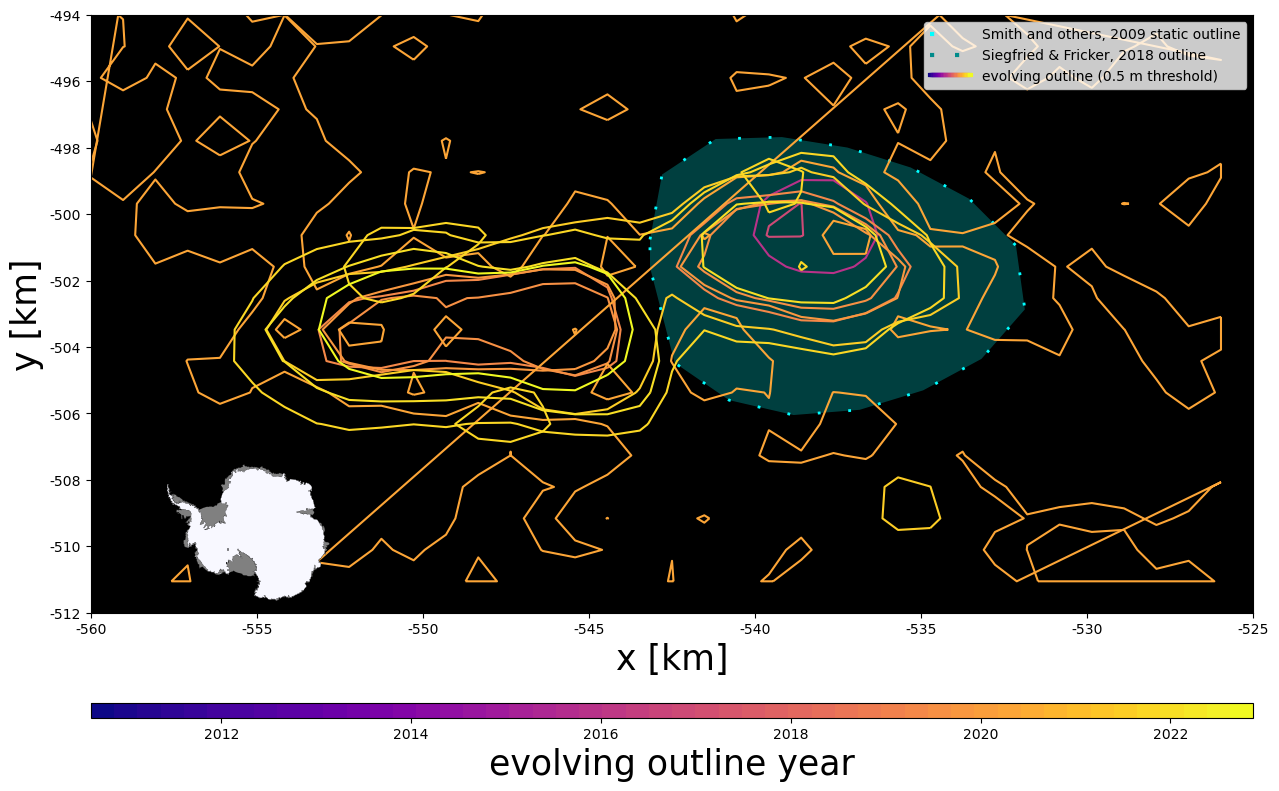

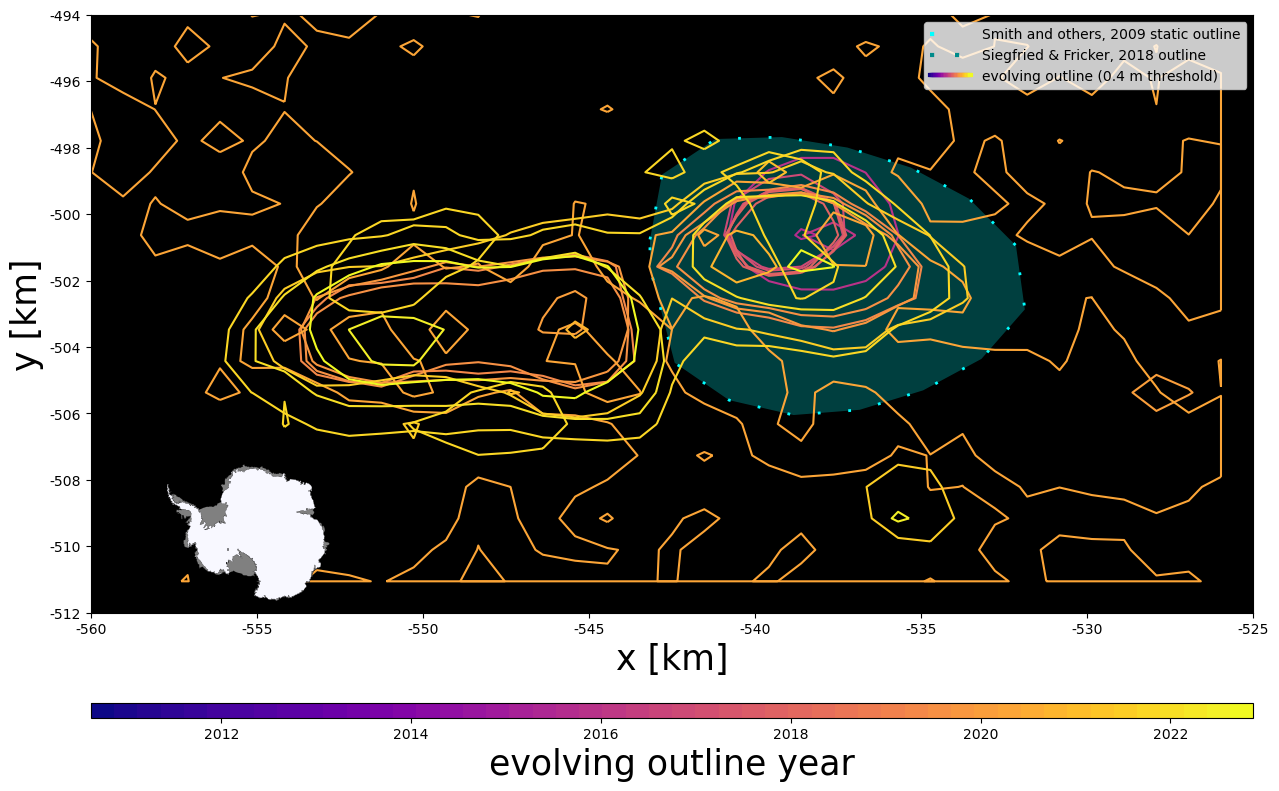

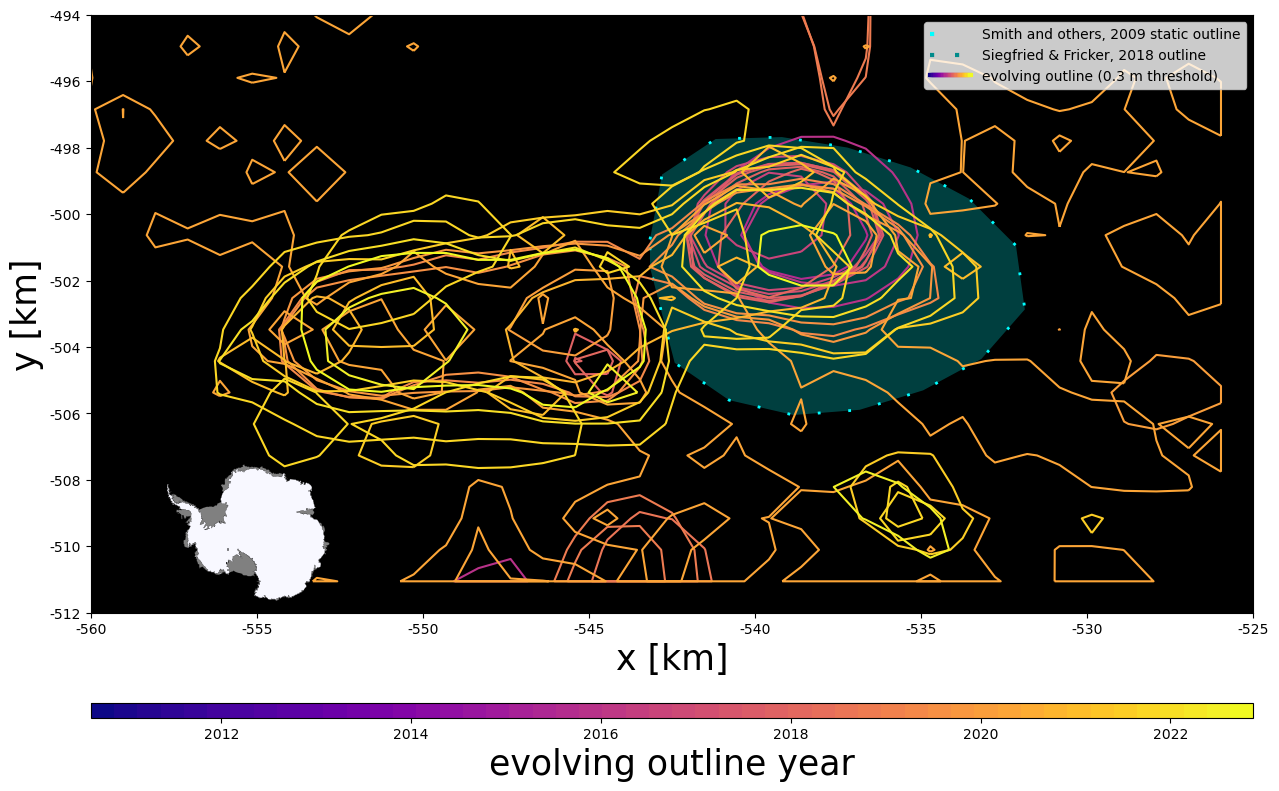

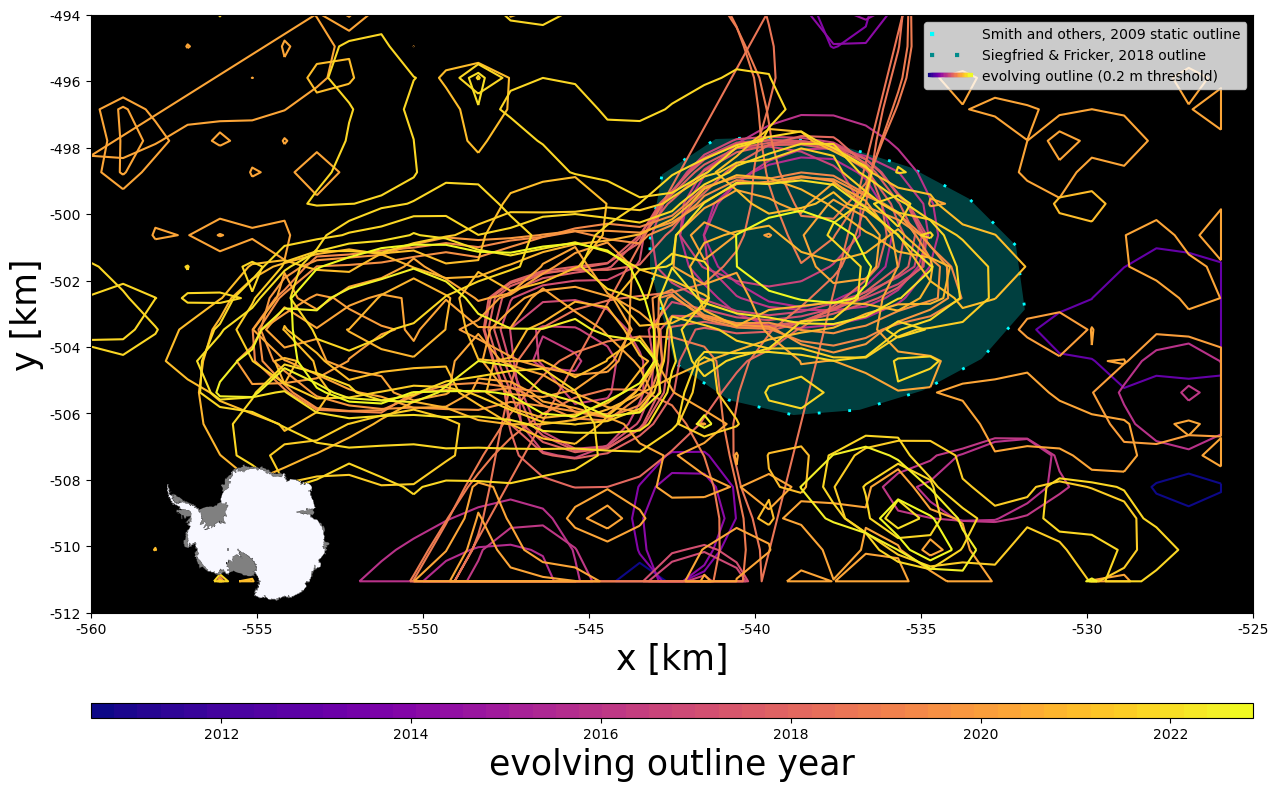

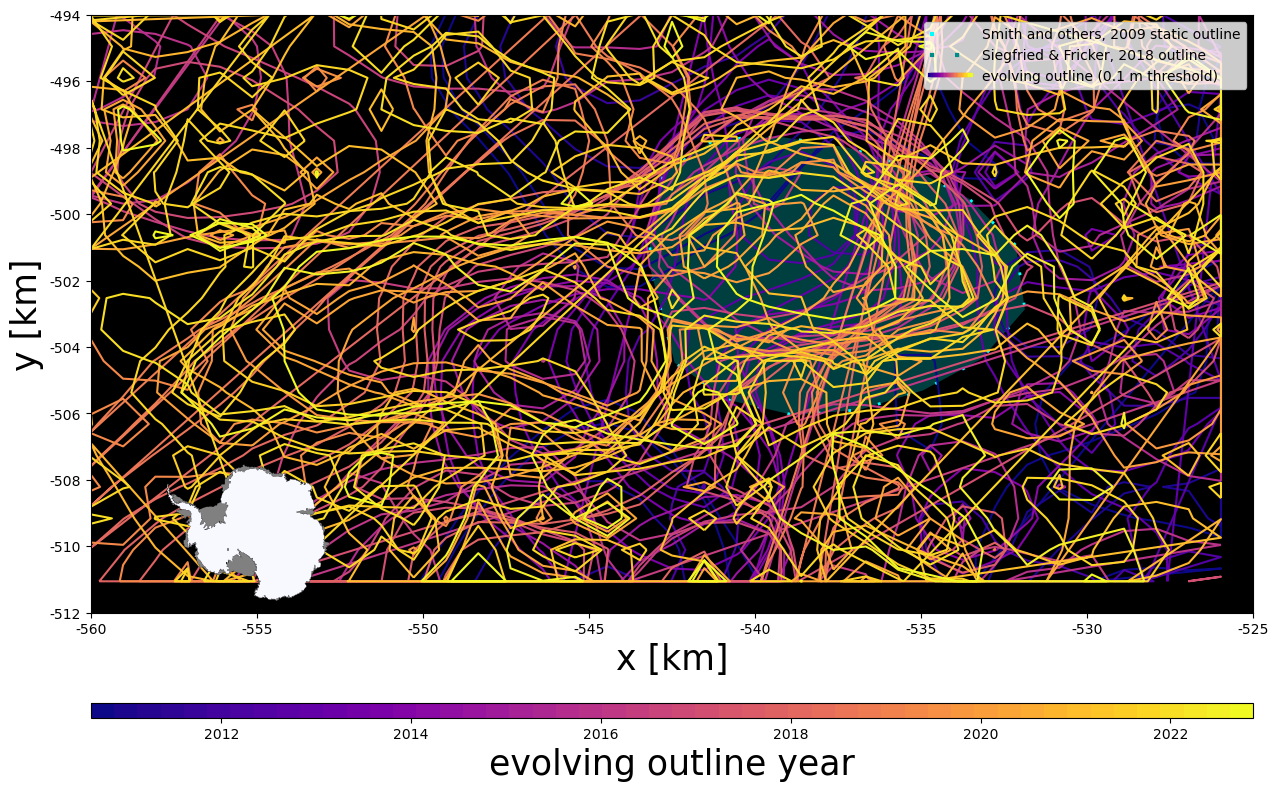

In [283]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
for threshold in thresholds: 
    gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, CS2_dh, ATL15_dh)
    plot_evolving_outlines_time_series(gdf)

In [ ]:
threshold = 0.5 #, 0.4, 0.3, 0.2, 0.1]
gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, CS2_dh, ATL15_dh)

In [157]:
plot_evolving_outlines_time_series(gdf)

In [89]:
gdf_overlapping = find_overlapping_polygons(gdf)

In [158]:
plot_evolving_outlines_time_series(gdf_overlapping)

In [220]:
gdf_filtered = remove_outlier_polygon(gdf_overlapping, 'x', 'min')

Removed polygon with extreme min x-value at index 12.


In [219]:
plot_evolving_outlines_time_series(gdf_filtered)

In [230]:
gdf_filtered = remove_outlier_polygon(gdf_filtered, 'x', 'max')

Removed polygon with extreme max x-value at index 21.


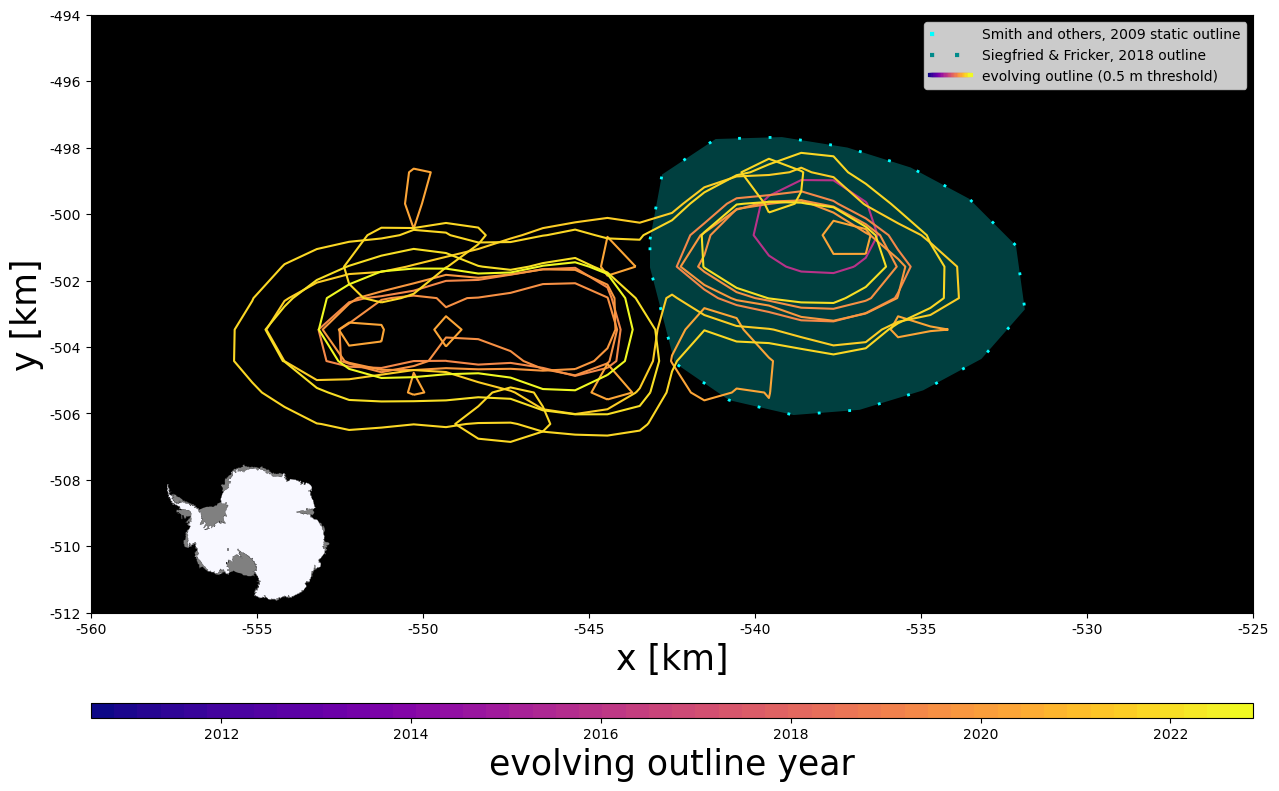

In [231]:
plot_evolving_outlines_time_series(gdf_filtered)

In [241]:
create_dirs(['csv_export'], OUTPUT_DIR + '/figX_subglacial_lake_areas/')

Folder 'csv_export' created at '/home/jovyan/1_outlines_candidates/output/figX_subglacial_lake_areas/csv_export'


In [266]:
csv_export(ROI, gdf_filtered)

In [267]:
create_dirs(['plot_evolving_outlines_dArea'], OUTPUT_DIR + '/figX_subglacial_lake_areas/')

Folder 'plot_evolving_outlines_dArea' created at '/home/jovyan/1_outlines_candidates/output/figX_subglacial_lake_areas/plot_evolving_outlines_dArea'


NameError: name 'ax' is not defined

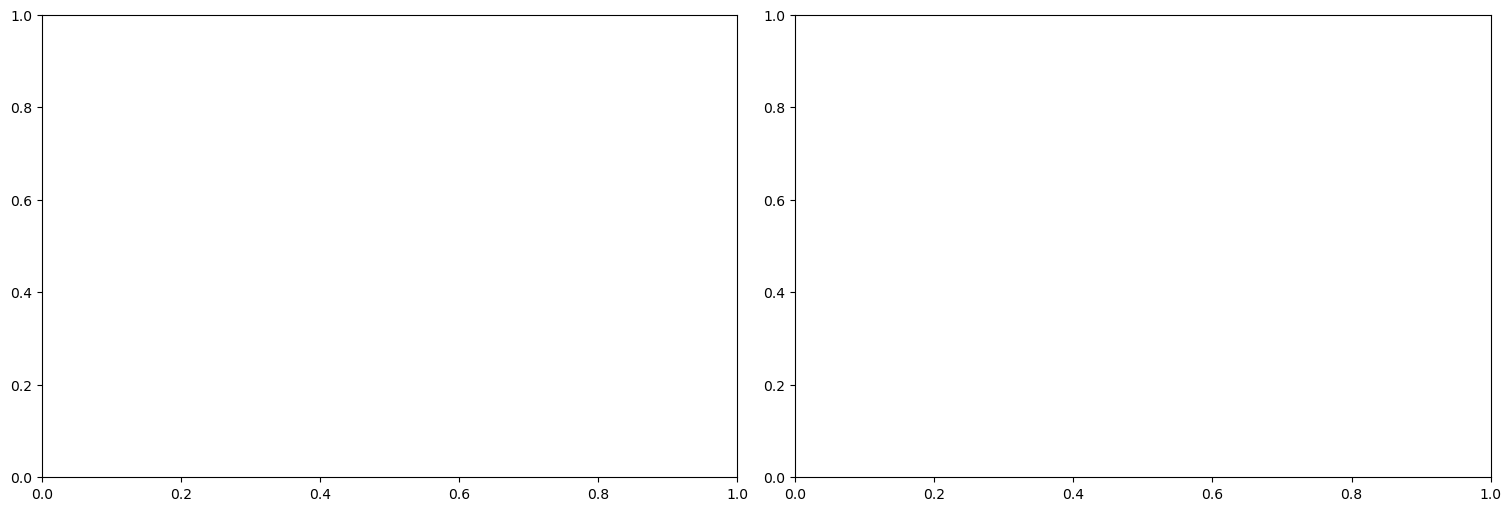

In [268]:
plot_evolving_outlines_dArea(ROI, gdf_filtered)

In [70]:
Sauthoff2023_outlines_CS2 = Sauthoff2023_outlines[Sauthoff2023_outlines['CS2_SARIn'] == 'True']
Sauthoff2023_outlines_CS2

,name,geometry,area (m^2),perimeter (m),cite,CS2_SARIn
8,Byrd_s1,"POLYGON ((485674.120 -925528.902, 487712.653 -...",171863914.946893,49204.386135,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
16,Byrd_s3,"POLYGON ((448649.741 -765043.898, 450532.915 -...",72932128.718063,30837.26921,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
23,ConwaySubglacialLake,"POLYGON ((-312825.002 -511425.001, -312699.997...",266997275.678752,93967.290533,"Fricker & Scambos, 2009, J. Glac., doi:10.3189...",True
24,Cook_E1,"POLYGON ((829182.800 -1794308.733, 830125.592 ...",264209761.756098,60912.169435,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
25,Cook_E2,"POLYGON ((765592.392 -1714713.856, 765682.174 ...",268093316.155226,127109.861123,"McMillan and others, 2013, Geophys. Res. Lett....",True
26,David_1,"POLYGON ((602372.876 -1478703.451, 603495.338 ...",959920029.875875,115518.929731,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
27,David_s1,"POLYGON ((660030.476 -1451099.814, 661929.661 ...",192917080.622368,49712.162343,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
41,EngelhardtSubglacialLake,"POLYGON ((-271824.984 -628674.969, -271699.995...",357763201.513295,122225.431584,"Fricker & Scambos, 2009, J. Glac., doi:10.3189...",True
42,Foundation_1,"POLYGON ((-558303.980 312113.150, -556309.653 ...",196102740.6799,54407.011135,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
50,Foundation_2,"POLYGON ((-502447.609 323781.186, -500635.007 ...",71652683.794769,30708.363593,"Smith and others, 2009, J. Glac., doi:10.3189/...",True


In [ ]:
# Do just lakes with CS2 coverage for now until modify func
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
for idx in range(len(Sauthoff2023_outlines)):
    ROI = Sauthoff2023_outlines_CS2['name'].iloc[idx]
    buffer = 5000
    x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

    for threshold in thresholds:
        gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, CS2_dh, ATL15_dh)
        plot_evolving_outlines_time_series(gdf)

In [ ]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
for idx in range(len(Sauthoff2023_outlines)):
    ROI = Sauthoff2023_outlines['name'][idx]
    buffer = 5000
    x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

    for threshold in thresholds:
        gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, CS2_dh, ATL15_dh)
        plot_evolving_outlines_time_series(gdf)

# Scrap code

In [ ]:
# Editing to stitch CS2 and IS2 data together

thres=0.5
dataset1=CS2_dh
dataset2=ATL15_dh

lake_S09 = Smith2009_outlines[(Smith2009_outlines['Name'] == 'Whillans_7')]
lake_SF18 = SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == 'Whillans_7']
S09_color = 'lightseagreen'
SF18_color = 'teal'

# Manually set because of new lake lobe
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

# Subset dataset and MOA imagery to region of interest using data masks
mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
ds_sub1 = dataset1.where(mask_x & mask_y, drop=True)
mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
ds_sub2 = dataset2.where(mask_x & mask_y, drop=True)
# mask_x = (moa_highres_da.x >= x_min) & (moa_highres_da.x <= x_max)
# mask_y = (moa_highres_da.y >= y_min) & (moa_highres_da.y <= y_max)
# moa_highres_da_sub = moa_highres_da.where(mask_x & mask_y, drop=True)

# get dates
dates = []
for idx in range(len(dataset1.delta_h[:-12])):
    dhdt = dataset1.delta_h[idx+1,:,:]-dataset1.delta_h[idx,:,:]
    # calculate mid-cycle dates for plotting
    newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
    newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
for idx in range(len(dataset2.delta_h)-1): 
    dhdt = dataset2.delta_h[idx+1,:,:]-dataset2.delta_h[idx,:,:]
    date_time_str = '18-01-01'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
    newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
        
# Pick colormap and make continuous cmap discrete
cmap = cm.get_cmap('plasma', len(dates)-1)
# Norm to time variable
norm = plt.Normalize(ds_sub1.time.values[0], ds_sub2.time.values[-1])

# Plot figure
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(10,5))#, gridspec_kw={'width_ratios': [2, 1, 1], 'height_ratios': [1]})

# Overlay published active lake outlines for visual comparison
Smith2009_outlines.boundary.plot(ax=axs[0], facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
Smith2009_outlines.boundary.plot(ax=axs[0], edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)

# Set axes limits
axs[0].set(#xticks=[], yticks=[], 
           xlim=(x_min, x_max), ylim=(y_min, y_max))

# Change polar stereographic m to km for cleaner-looking axes
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].yaxis.set_major_formatter(ticks_y)  

# Label axes
axs[0].set_xlabel('x [km]', size=20)
axs[0].set_ylabel('y [km]', size=20)

# Create lines for legend
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 5)), linewidth=4)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=3)
subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=3)

# Plot inset map to show location 
axIns = axs[0].inset_axes([0.72, 0.68, 0.5, 0.5]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1) 
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=150, zorder=3)
axIns.axis('off')

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([datetime2fracyear(date) for date in dates[0:]]))
cax = inset_axes(axs[0],
                    width="100%",  
                    height="10%",
                    loc='lower center',
                    borderpad=-7
                   )
fig.colorbar(m, cax=cax, orientation='horizontal').set_label('Variable lake outline year', size=15)

# Create empty lists to store calculated data
lkavgdhdt_S09 = []
lkavgdhdt_SF18 = []
lkavgdhdt_var = []
areas_var = []
vols_S09 = []
vols_SF18 = []
vols_var = []

for idx in range(len(dates)-1):
    # Stitch together CryoSat-2 and ICESat-2 time series
    if idx < 35:
        dhdt = ds_sub1.delta_h[idx+1,:,:]-ds_sub1.delta_h[idx,:,:]
    elif idx > 34:
        dhdt = ds_sub2.delta_h[(idx-40)+1,:,:]-ds_sub2.delta_h[(idx-40),:,:]

    # Clip dh/dt to published static outlines
    dhdt.rio.write_crs(3031, inplace=True)
    dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
    dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)

    # Calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
    avg_lk_dhdt_S09 = np.nanmean(dhdt_clip_S09)
    avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
    lkavgdhdt_S09 += [avg_lk_dhdt_S09]
    lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
    vol_S09 = avg_lk_dhdt_S09*sum(lake_S09.area) # FIXME: change to geodesic area
    vol_SF18 = avg_lk_dhdt_SF18*sum(lake_SF18.area)
    vols_S09 += [vol_S09]
    vols_SF18 += [vol_SF18]

    # Create contours of ice surface elevation height changes to delineate lake outlines
    contours_fill = []
    contours_drain = []
    polys = []
    contour = measure.find_contours(dhdt.values, thres)
    if len(contour) > 0: 
        contours_fill += [contour]
    contour = measure.find_contours(dhdt.values, -thres)
    if len(contour) > 0: 
        contours_drain += [contour]

    # Create mapping conversion factor to map array location to polar stereographic x,y
    x_conv = (x_max-x_min)/dhdt.shape[1]
    y_conv = (y_max-y_min)/dhdt.shape[0]

    # Plot and make polygons from variable outlines
    for i in range(len(contours_fill)): 
        for j in range(len(contours_fill[i])):
            if len(contours_fill[i][j][:, 1]) > 2: 
                axs[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                    # color=cmap(norm(dates[idx])), 
                    linestyle=(0, (3, 1, 1, 1)), linewidth=1, zorder=3)
                poly = Polygon(list(zip(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv)))
                polys += [poly]
    for i in range(len(contours_drain)): 
        for j in range(len(contours_drain[i])):
            if len(contours_drain[i][j][:, 1]) > 2: 
                axs[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                    # color=cmap(norm(dates[idx])), 
                    linestyle=(0, (5, 1)), linewidth=1, zorder=3)
                poly = Polygon(list(zip(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                polys += [poly]

    # Start with baseline variable outline area of zero
    area_var = 0
    # If polygons are present at time step, 
    if len(polys) > 0: 
        # Clip data to polygons 
        dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
        # Then calculate on-lake averages of dh/dt
        avg_lk_dhdt = np.nanmean(dhdt_clip)
        # Occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
        # eplace with zeros
        if math.isnan(avg_lk_dhdt): 
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
        else:
            lkavgdhdt_var += [avg_lk_dhdt]                
        # and dv/dt
        for i in range(len(polys)):
            area_var = area_var + polys[i].area # TODO: CHANGE TO GEODESIC AREA
        # Store areas in list 
        areas_var += [area_var]
        # Calculate and store volumes in list
        vol_var = avg_lk_dhdt*area_var
        vols_var += [vol_var]
    else: 
        # Store areas in list 
        areas_var += [area_var]
        # Set lake dhdt to zero because no variable outline polygons
        avg_lk_dhdt = 0
        # Store dhdt's in list 
        lkavgdhdt_var += [avg_lk_dhdt]
        # Calculate variable volumes
        vol_var = avg_lk_dhdt*area_var
        # Store variable volumes in list
        vols_var += [vol_var]

# Calculate bias
# S09_var_dh_bias = [a_i - b_i for a_i, b_i in zip(lkavgdhdt_var, lkavgdhdt_S09)]
# S09_var_vol_bias = [a_i - b_i for a_i, b_i in zip(np.cumsum(vols_var), np.cumsum(vols_S09))]

# Plot 1 - plot area change time series
axs[1].axhline(np.divide(sum(lake_S09.area), 1e6), color=S09_color, linestyle=(0, (1, 5)))
axs[1].plot(dates[:idx+1], np.divide(areas_var[:idx+1], 1e6), color='k', linestyle='solid')
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)
min_area = min(np.divide(sum(lake_S09.area), 1e6), 
                np.divide(sum(lake_SF18.area), 1e6), 
                min(np.divide(np.cumsum(areas_var),1e6)))
max_area = max(np.divide(sum(lake_S09.area), 1e6), 
                np.divide(sum(lake_SF18.area), 1e6), 
                max(np.divide(np.cumsum(areas_var),1e6)))
axs[1].set(ylim=((min_area - (max_area - min_area)*0.05), (max_area + (max_area - min_area)*0.05)))
axs[1].set_ylabel('area [km$^2$]', size=17.5, labelpad=4)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
variable_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle='solid', linewidth=3)
legend2 = axs[1].legend([Smith2009,
    #SiegfriedFricker2018,
    variable_outlines],
                ['static outline',
    #'Siegfried & Fricker, 2018 static outline',
    # '±{} m variable outlines'.format(thres)], 
    'variable outlines'],
    loc='upper right')
legend2.get_frame().set_linewidth(0.0)
axs[1].patch.set_alpha(1)

# # Plot 2 - height change time series
# axs[2].plot(dates[:-1], lkavgdhdt_S09, color=S09_color, linestyle=(0, (1, 5)))
# axs[2].plot(dates[:-1], lkavgdhdt_var, color='k', linestyle='solid')
# axs[2].plot(dates[:-1], S09_var_dh_bias, color='r', linestyle='solid')
# locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
# formatter = mdates.ConciseDateFormatter(locator)
# axs[2].xaxis.set_major_locator(locator)
# axs[2].xaxis.set_major_formatter(formatter)
# axs[2].set_xlabel('year', size=17.5)
# axs[2].set_ylabel('height change [m]', size=17.5, labelpad=5)
# axs[2].yaxis.tick_right()
# axs[2].yaxis.set_label_position("right")
# bias = plt.Line2D((0, 1), (0, 0), color='r', linestyle='solid', linewidth=3)
# legend = axs[2].legend([#Smith2009,
#     #SiegfriedFricker2018,
#     bias],
#                 [#'static outline',
#     #'Siegfried & Fricker, 2018 static outline',
#     # '±{} m variable outlines'.format(thres)], 
#     'bias'],
#     loc='lower right')
# legend.get_frame().set_linewidth(0.0)
# axs[2].patch.set_alpha(1)

# # Plot 3 - volume change time series
# axs[3].plot(dates[:-1], np.divide(np.cumsum(vols_S09), 1e+9), color=S09_color, linestyle=(0, (1, 5)))
# axs[3].plot(dates[:-1], np.divide(np.cumsum(vols_var), 1e+9), color='k', linestyle='solid')
# axs[3].plot(dates[:-1], np.divide(S09_var_vol_bias, 1e+9), color='r', linestyle='solid')
# locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
# formatter = mdates.ConciseDateFormatter(locator)
# axs[3].xaxis.set_major_locator(locator)
# axs[3].xaxis.set_major_formatter(formatter)
# min_vol = min(np.divide(min(np.cumsum(vols_S09)), 1e+9), 
#             #   np.divide(min(np.cumsum(vols_SF18)), 1e+9), 
#                 np.divide(min(np.cumsum(vols_var)), 1e+9))
# max_vol = max(np.divide(max(np.cumsum(vols_S09)), 1e+9), 
#             #   np.divide(max(np.cumsum(vols_SF18)), 1e+9), 
#                 np.divide(max(np.cumsum(vols_var)), 1e+9))

# axs[3].set(xlim=(dates[0], dates[-1]), 
#             ylim=((min_vol - (max_vol - min_vol)*0.05),
#                     (max_vol + (max_vol - min_vol)*0.05)))
# axs[3].set_xlabel('year', size=17.5)
# axs[3].set_ylabel('vol. change [km$^3$]', size=17.5, labelpad=0)
# axs[3].yaxis.tick_right()
# axs[3].yaxis.set_label_position("right")
# axs[3].patch.set_alpha(1)

# Save and close figure
# plt.savefig('/Users/Wilson/Documents/0-code/output/output_S09SF18varoutlines-visual-imagery/S09SF18varoutlines_agg_moa_plot/regions/S09SF18varoutlines_agg_moa_plot-{}-{}.png'.format(region_name,dataset.Title), dpi=300, bbox_inches = "tight") # change to name after region name given as func input?
# plt.close()
plt.show()

In [ ]:
# TODO
# (left) colormap of outlines not matching colorbar
# (right) fix y axis bounds on da/dt plot

In [ ]:
def S09SF18S23_outline_timeseries_gdf(ROI, buffer, threshold, dataset1, dataset2):
    '''
    Create time series of variable outlines compared to known lakes or across a larger region 
    to additionally find lake candidates. Uses geopandas buffer created bounding box around 
    previously  identified lakes in Siegfried and Fricker, 2018 (SF18) inventory if lake is input.
    Creates contours of surface-height change using skimage contour to create evolving outlines. 
    
    Inputs: 
        ROI: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from lake outline used to create bounding box that is displayed around lake of interest
        threshold: vertical distance in meters to delineate ice surface deformation contour
        dataset1: dataset to be analyzed (CS2_dh or CS2SARIn_elev)
        dataset2: dataset to be analyzed (ATL15_dh)
    
    Outputs: 
        gdf: geodataframe of variable outlines
    '''
    
    x_min, x_max, y_min, y_max = find_bbox_coords(ROI, buffer)    
    
    # Subset CryoSat-2 SARIn data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
    
    # Subset ATL15 data set to region of interest
    mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    datetimes = []

    # Find mid-cycle dates of combined CS2 and IS2 data
    dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
    for idx in range(len(dataset2.delta_h)-1): 
        if dataset2.identifier_product_DOI == 'NOT SET':    
            print('working')
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            cyc_end_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]

    # Calculate cycle-to-cycle dh/dt at each cycle of the spliced data sets
    for idx in range(len(dates)-1): 
        if idx < 35:
            dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds1_clipped.delta_h[idx,:,:]
            midcycdate = dates[idx]
        elif idx > 34:
            dhdt = ds2_clipped.delta_h[(idx-40)+1,:,:]-ds2_clipped.delta_h[idx-40,:,:]
            midcycdate = dates[idx]
       
        # Create empty lists to store contours 
        contours_pos = []
        contours_neg = []

        # Create contours of ice surface elevation height changes to delineate variable lake outlines
        contour = measure.find_contours(dhdt.values, threshold)
        if len(contour) > 0: 
            contours_pos += [contour]
        contour = measure.find_contours(dhdt.values, -threshold)
        if len(contour) > 0: 
            contours_neg += [contour]

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]

        # Make contours and make into polygons
        for i in range(len(contours_pos)): 
            for j in range(len(contours_pos[i])):
                x = x_min+contours_pos[i][j][:,1]*x_conv
                y = y_max-contours_pos[i][j][:,0]*y_conv

                # Make polygons from variable outlines and store to list
                if len(contours_pos[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x, y))) 
                    polys += [poly]

                    # Calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6  # km^2
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3  # km
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]

        for i in range(len(contours_neg)): 
            for j in range(len(contours_neg[i])):
                x = x_min+contours_neg[i][j][:,1]*x_conv
                y = y_max-contours_neg[i][j][:,0]*y_conv

                # Make polygons from variable outlines
                if len(contours_neg[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x, y)))
                    polys += [poly]

                    # Calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]
    
    # Store polygons in geopandas geodataframe for analysis
    d = {'geometry': polys, 'area (km^2)': areas, 'perim (km)': perims, 'datetime': datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['date'] = pd.to_datetime(gdf['datetime']).apply(lambda x: x.date())
    gdf['centroid'] = gdf['geometry'].centroid
    
    return gdf

In [ ]:
gdf = S09SF18S23_outline_timeseries_gdf('Whillans_7', 20000, 0.1, CS2_dh, ATL15_dh)
gdf

In [ ]:
# Remove polygons with area above the 95th percentile and below the 5th percentile
gdf2 = gdf[(gdf['area (km^2)'] < gdf['area (km^2)'].quantile(0.99)) &
           (gdf['area (km^2)'] > gdf['area (km^2)'].quantile(0.01))]

In [ ]:
plt.plot(gdf2_overlapping_remove_outliers['date'], gdf2_overlapping_remove_outliers['area (km^2)'], 'o')
plt.show()